In [135]:
import pandas as pd
import numpy as np
import datetime as dt

In [136]:
## Import Google Mobility data

data =  pd.read_csv(r"C:\Users\misko\OneDrive\Desktop\BDS\Block 3\Research Hackathon I\EconomicTracker_Covid\EconomicTracker\data\Google Mobility - State - Daily.csv")
# data.head(55)

In [137]:
## Create panel structure per year, per week, per state

df = data.copy()
df.insert(3, "date", pd.to_datetime(df[["year", "month", "day"]])) # create date column
df.insert(4, "week", df["date"].dt.strftime("%W"))                 # create week of the year column
df = df.groupby(["year", "week", "statefips"]).mean()              # group by year, week & state
df = df.drop(columns = ["month", "day"]).reset_index()             # keep year, week & state as variables
df["year"] = df["year"].astype(int)
df["week"] = df["week"].astype(int)

In [138]:
## Get the policy data with start dates and end dates of stay-at-home advisories

policy = pd.read_csv(r"C:\Users\misko\OneDrive\Desktop\BDS\Block 3\Research Hackathon I\EconomicTracker_Covid\EconomicTracker\data\Policy Milestones - State.csv")
policy = policy[['statefips', 'nonessential_biz_closed',
                 'stayathome_start', 'statewide_biz_opened', 
                 'statewide_stayathome_end']]

def dates_to_weeks(x):
    x = pd.to_datetime(x, errors = "ignore")    # change type to date-time
    x = x.dt.strftime("%W")                     # get week of the year
    x = x.astype(float)                         # convert to floats (integers don't work due to NaNs)
    return x

policy.iloc[:,1:] = policy.iloc[:,1:].apply(lambda x: dates_to_weeks(x))            # apply transformations

In [139]:
## Create stay-at-home dummy

lockdowns = df[["year", "week", "statefips"]].copy()                                # copy only the panel structure
lockdowns["week"] = lockdowns["week"].astype(float)                                 # convert week & year to floats
lockdowns["year"] = lockdowns["year"].astype(int)

lockdowns = lockdowns.merge(policy, right_on = "statefips", left_on = "statefips")  # merge policy and weekly state panel
lockdowns.sort_values(by = ["year", "week", "statefips"],                           # sort back to panel format
                      inplace = True, ignore_index = True) 

lockdowns["stayathome_advisory"] = np.where(((lockdowns["week"] >= lockdowns["stayathome_start"]) &
                                             (lockdowns["week"] <= lockdowns["statewide_stayathome_end"]) &
                                              (lockdowns["year"] == 2020)), 1, 0)              # create stay-at-home dummy
lockdowns["nonessbiz_closed"] = np.where(((lockdowns["week"] >= lockdowns["nonessential_biz_closed"]) &
                                             (lockdowns["week"] <= lockdowns["statewide_biz_opened"]) &
                                              (lockdowns["year"] == 2020)), 1, 0)              # create closed_biz dummy

## Add dummies to mobility panel data

df = df.join(lockdowns[["stayathome_advisory", "nonessbiz_closed"]])
df["isolation_dummy"] = np.where(df["gps_away_from_home"] < np.median(df["gps_away_from_home"]), 1, 0)

## Export to csv

df.to_csv("covid_mobility_panel_per_state.csv")

In [175]:
## Merge the Full Panel

covid_cases = pd.read_csv(r"C:\Users\misko\OneDrive\Desktop\BDS\Block 3\Research Hackathon I\EconomicTracker_Covid\EconomicTracker\Panel_structure_preprocessing\covid_panel.csv")
spending = pd.read_csv(r"C:\Users\misko\OneDrive\Desktop\BDS\Block 3\Research Hackathon I\EconomicTracker_Covid\EconomicTracker\Panel_structure_preprocessing\spending_panel.csv")

spending = spending.iloc[: , 1:]
covid_cases = covid_cases.iloc[: , 1:]

big_df = spending.merge(df, how = 'inner', on = ["year", "week", "statefips"])
big_df = big_df.merge(covid_cases, how = 'inner', on = ["year", "week", "statefips"])

big_df.to_csv("covid_spending_cases_mobility_panel.csv")

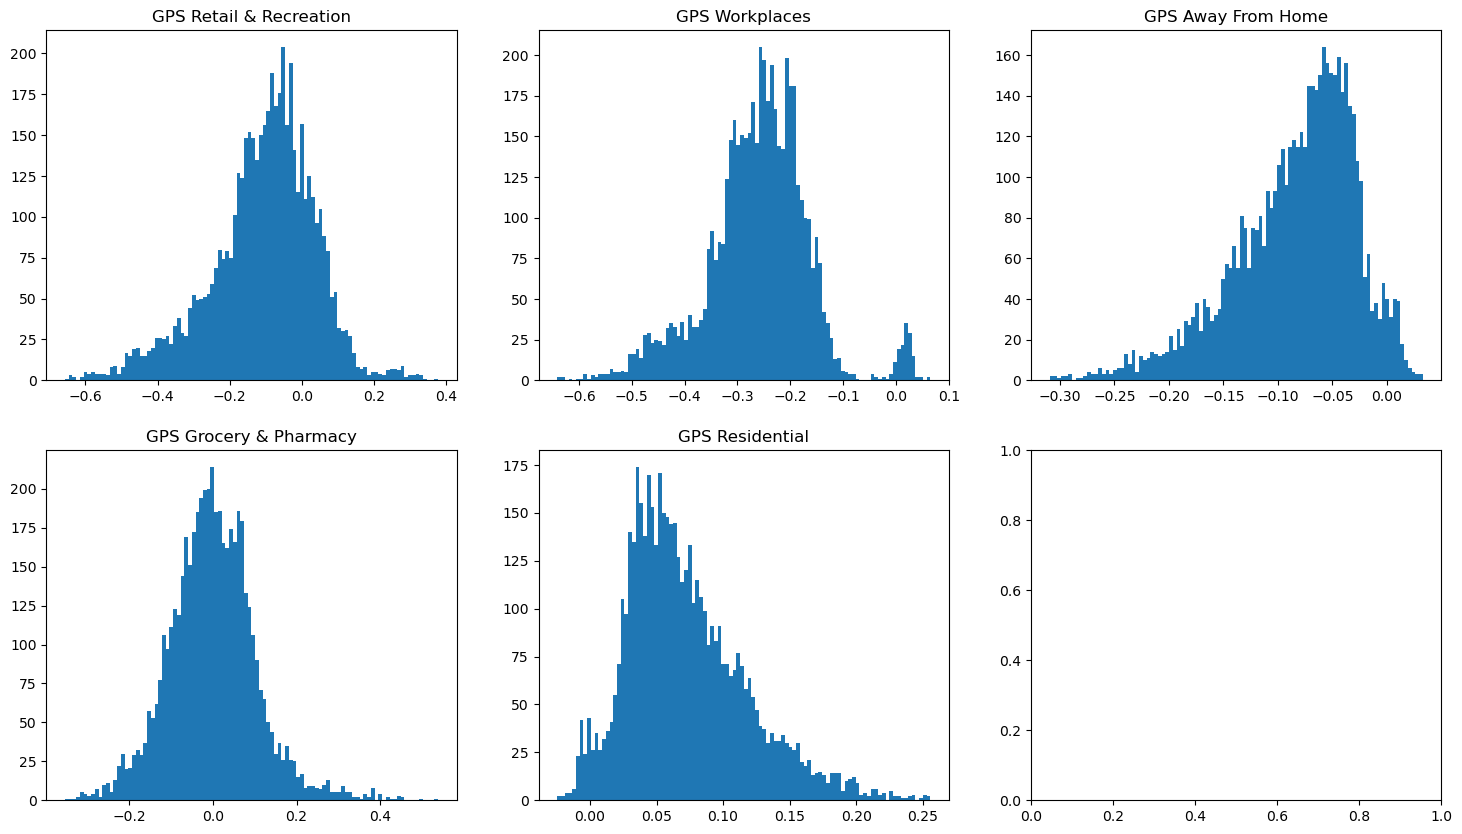

In [67]:
## Visualize Mobility Index Distributions
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 2, ncols =3, figsize = (18,10))
ax[0,0].hist(df["gps_retail_and_recreation"], bins = 100)
ax[0,0].set_title("GPS Retail & Recreation")

ax[0,1].hist(df["gps_workplaces"], bins = 100)
ax[0,1].set_title("GPS Workplaces")

ax[0,2].hist(df["gps_away_from_home"], bins = 100)
ax[0,2].set_title("GPS Away From Home")

ax[1,0].hist(df["gps_grocery_and_pharmacy"], bins = 100)
ax[1,0].set_title("GPS Grocery & Pharmacy")

ax[1,1].hist(df["gps_residential"], bins = 100)
ax[1,1].set_title("GPS Residential")
plt.show()

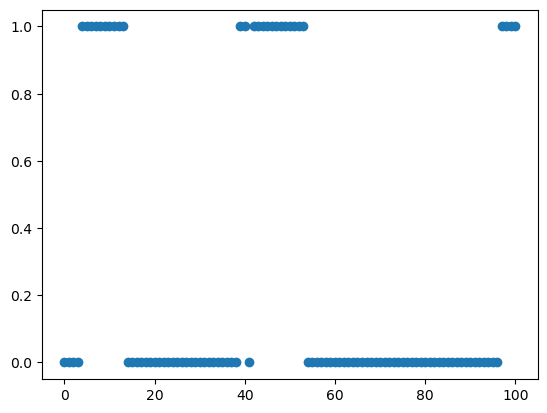

In [97]:
df["isolation_dummy"] = np.where(df["gps_away_from_home"] < np.median(df["gps_away_from_home"]), 1, 0)
plt.scatter(list(range(101)),df[df["statefips"] == 5].isolation_dummy)
plt.show()